In [1]:

import os
import torch
import numpy as np
import seaborn as sns
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete


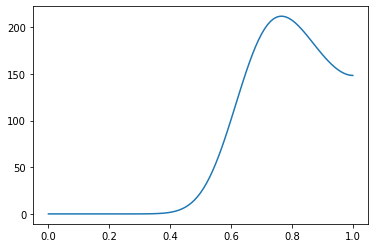

In [2]:

import numpy as np
import matplotlib.pyplot as plt

gc = np.linspace(0, 1, 101)

# Hand built polynomial
betas = np.array([0.1, 0.2, -1, 1, -0.25]) * 100.

p1d = np.poly1d(betas)

mean = np.exp(p1d(gc))

plt.plot(gc, mean)


In [3]:


def make_features(x, poly_degree=4):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in reversed(range(0, poly_degree+1))], 1)


def model_GC(data=None, n_data=None, poly_degree=4):
    assert (n_data is None) != (data is None)

    if data is not None:
        n_data = data.shape[0]

    # Sample betas from a normal
    betas = pyro.sample('betas', dist.Normal(0., 1.).expand([poly_degree+1]).to_event(1))

    with pyro.plate('n_data', n_data):
        # Sample some gc values from 0 to 1
        gc = pyro.sample('gc', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        gc_features = make_features(gc, poly_degree=poly_degree)

        rate = torch.exp(torch.sum(betas * gc_features, 1))

        pyro.sample('counts', dist.Poisson(rate), obs=data)



/juno/work/shah/users/mcphera1/repos/dlpanalysis/noisybins/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

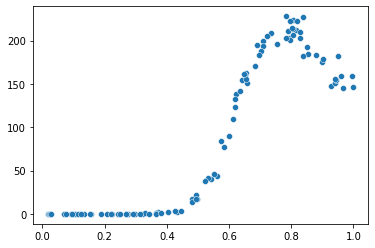

In [4]:

pyro.clear_param_store()

conditioned_model = poutine.condition(
    model_GC,
    data={
#         'gc': torch.tensor([0.1, 0.5, 0.3]),
        'betas': torch.tensor((np.array([0.1, 0.2, -1, 1, -0.25]) * 100.).astype(np.float32))
#         'betas': torch.tensor([-5.9305, -3.2150,  5.8977, 10.0505, -2.3108]),
    })

model_trace = pyro.poutine.trace(conditioned_model)

samples = model_trace.get_trace(n_data=100)

gc = samples.nodes['gc']['value']
counts = samples.nodes['counts']['value']

sns.scatterplot(gc, counts)


In [5]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)


In [6]:

conditioned_model = poutine.condition(
    model_GC,
    data={
# Uncomment to condition on various hidden variables
        'gc': gc,
#         'betas': betas,
    })

guide = AutoDelta(
    poutine.block(conditioned_model, expose=['betas']),
)
svi = SVI(conditioned_model, guide, optim, loss=elbo)


In [7]:

# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model, guide, data=counts, poly_degree=4)


/juno/work/shah/users/mcphera1/repos/dlpanalysis/noisybins/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py:356: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  "TraceEnum_ELBO found no sample sites configured for enumeration. "


47870.0859375

In [8]:

# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(data=counts, poly_degree=4)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

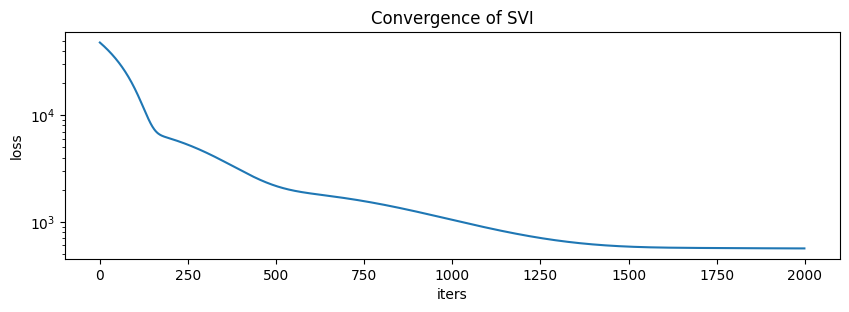

In [9]:

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');


In [10]:

for k in pyro.get_param_store():
    print(k, pyro.get_param_store()[k])


AutoDelta.betas Parameter containing:
tensor([-5.7119, -2.8471,  5.5616,  9.4928, -1.9136], requires_grad=True)


In [11]:

(np.array([0.1, 0.2, -1, 1, -0.25]) * 100.)


array([  10.,   20., -100.,  100.,  -25.])